In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance

Loading final data

In [2]:
data = pd.read_pickle('final_data.pkl')

In [6]:
sample_submission=pd.read_csv("sample_submission.csv.gz.filepart", compression='gzip')

Select perfect feature

In [3]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [4]:
X_train = data[data.date_block_num < 34].drop(['item_cnt_month'], axis=1)
y_train = data[data.date_block_num < 34]['item_cnt_month'].values
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

# Modeling

## Linear Regression

In [5]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values).clip(0,20)

/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [7]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lr})
submission.to_csv('submission/submission_linear_regression.csv', index=False)

submission.head()

,ID,item_cnt_month
0,0,0.471836
1,1,0.364795
2,2,1.142725
3,3,0.297276
4,4,0.385724


In [8]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7,
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test).clip(0,20)

In [9]:
pkl_filename = "lgb_classifier.pkl"  
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [10]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lgb})
submission.to_csv('submission/submission_lgb.csv', index=False)

### Concatenate test predictions to get test meta-features

In [11]:
X_test_level2 = np.c_[pred_lr, pred_lgb]

In [ ]:
dates=data['date_block_num']
dates_train=dates[dates<34]
dates_test=dates[dates==34]


### Train meta-feature

In [23]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(dates_train_level2)]

Time series data - Use 2nd level validation scheme accordingly
KFold scheme in time series

In time-series task we usually have a fixed period of time we are asked to predict. Like day, week, month or arbitrary period with duration of T.

Split the train data into chunks of duration T. Select first M chunks.
Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.
Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.

In [24]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32, 33]:
    print(cur_block_num)
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    X_train_cur = data.loc[dates <  cur_block_num].drop('item_cnt_month', axis=1)
    X_test_cur =  data.loc[dates == cur_block_num].drop('item_cnt_month', axis=1)

    y_train_cur = data.loc[dates <  cur_block_num, 'item_cnt_month'].values
    y_test_cur =  data.loc[dates == cur_block_num, 'item_cnt_month'].values
    
    lr.fit(X_train_cur.values, y_train_cur)
    pred_lr = lr.predict(X_test_cur.values)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = pred_lr.clip(0,20)
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train_cur, label=y_train_cur), 100)
    pred_lgb = model.predict(X_test_cur)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = pred_lgb.clip(0,20)

27


/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


28


/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


29


/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


30


/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


31


/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


32


/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


33


/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Correlation between predictions of different methods

ERROR! Session/line number was not unique in database. History logging moved to new session 314


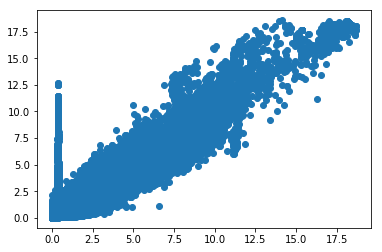

In [25]:
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])

### Ensembling - Simple averaging


(alpha) linear_regression + (1-alpha) lightgbm

In [26]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_scores = []
for alpha in alphas_to_try:
    mix = alpha*X_train_level2[:,0] + (1-alpha)*X_train_level2[:,1]
    r2_scores.append(r2_score(y_train_level2, mix))

r2_scores = np.array(r2_scores)

# YOUR CODE GOES HERE
best_alpha = alphas_to_try[r2_scores.argmax()]
r2_train_simple_mix = r2_scores.max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))


/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow

Best alpha: 0.089000; Corresponding r2 score on train: 0.428348


/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [27]:
pred_simple_averaging = best_alpha*X_test_level2[:,0] + (1-best_alpha)*X_test_level2[:,1]
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_simple_averaging})
submission.to_csv('submission/submission_simple_averaging.csv', index=False)


## Ensembling - Stacking

Train second level data

In [28]:
lr.fit(X_train_level2, y_train_level2)

/opt/python/python35/lib/python3.5/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [29]:
pred_stacking = lr.predict(X_test_level2).clip(0,20)

In [30]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_stacking})
submission.to_csv('submission/submission_stacking.csv', index=False)


In [31]:
pred_stacking

array([0.52091682, 0.44341766, 1.04259667, ..., 0.04293159, 0.02633434,
       0.04873029])